# Modeling

In this section, we will fit 3 different models on the dataset to predict the players' next year salary.

In [1]:
import statsmodels.api as sm
import statsmodels.api as sm
from sklearn import preprocessing
from sklearn.linear_model import RidgeCV
from sklearn.linear_model import LassoCV
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import RandomForestRegressor
import warnings
from functions import mse_func
from functions import split_train_test

In [2]:
%%capture
%run eda.ipynb

To fit any type of model, we first want to split our dataframe into X, our independent predictors, and y, our dependent variable. Our predictors are all columns except the column that we want to predict and y will be the singular 'Next_Year_Salary' column. After getting our X and y, we want to split each into training and test sets using an 80/20 split.

In [3]:
X = oh_df.drop(columns=['Next_Year_Salary'])
y = np.log(oh_df['Next_Year_Salary'])

X_train, X_test, y_train, y_test = split_train_test(X, y, 0.8, 42)

## Ordinary Least Squares (OLS)

The first model we will use to predict the players' next year salary is OLS. This is a linear model with an intercept term, using all features as predictors. 

In [4]:
X_new = sm.add_constant(X_train)
ols_model = sm.OLS(y_train, X_new).fit()
print(ols_model.summary())

                            OLS Regression Results                            
Dep. Variable:       Next_Year_Salary   R-squared:                       0.638
Model:                            OLS   Adj. R-squared:                  0.623
Method:                 Least Squares   F-statistic:                     44.16
Date:                Sun, 14 Dec 2025   Prob (F-statistic):          3.91e-111
Time:                        00:50:26   Log-Likelihood:                -621.12
No. Observations:                 601   AIC:                             1290.
Df Residuals:                     577   BIC:                             1396.
Df Model:                          23                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const          12.0871      0.550     21.976      

Now that we have fit our OLS model, we want to use this model to predict the players' next year salary for our test set. We also want to calculate the mean squared error for future comparison.

In [5]:
X_test_new = sm.add_constant(X_test)
ols_predictions = ols_model.predict(X_test_new)
ols_mse = mse_func(y_test, ols_predictions)
print(ols_mse)

0.7642872784423457


Since the MSE is only meaningful relative to other models' MSE, we will plot the residuals to see visually see how the OLS model is doing.

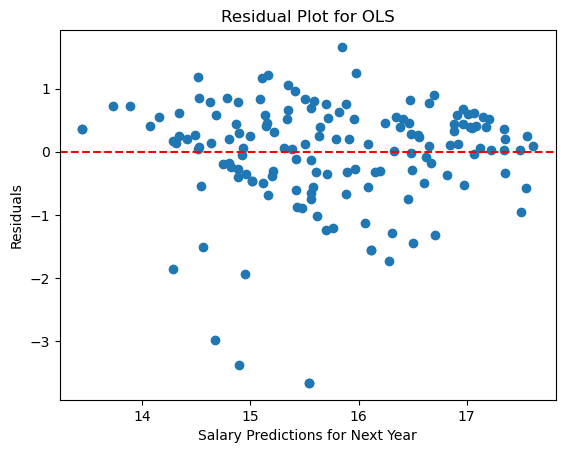

<Figure size 640x480 with 0 Axes>

In [6]:
ols_residuals = y_test - ols_predictions
plt.scatter(ols_predictions, ols_residuals)
plt.axhline(0, color='r', linestyle='--')
plt.title('Residual Plot for OLS')
plt.xlabel('Salary Predictions for Next Year')
plt.ylabel('Residuals')
plt.show()
plt.savefig("outputs/OLS_residual_plot.png")

Looking at the residual plot above, we see that the residuals are not entirely randomly scattered but are generally within the [-2, 2] range, which suggests there may be a better model for this dataset. There is a slight linear pattern of residuals that can be seen so a nonlinear model may be a better fit. 

## Ridge Regression

One downside of the OLS model is that it may overfit, especially when noise or multicollinearity exists in the dataset. To prevent overfitting, we will now use ridge regression to regularize the model by limiting the model's complexity.

Before actually fitting the model, we will first standardize the predictors since the predictors all have different units. This prevents predictors with very large or very small units from skewing the model. We apply this standardization to both the training and test set for X.

In [7]:
ss = preprocessing.StandardScaler()
X_train_ss = ss.fit_transform(X_train)
X_test_ss = ss.transform(X_test)

After standardization, we will now use ridge regression combined with 5-fold cross validation to find the best lambda/model.

In [8]:
lambdas = [0.001, 0.01, 0.1, 1, 10, 100]
ridge_model = RidgeCV(alphas=lambdas, cv=5)  
ridge_model.fit(X_train_ss, y_train)
ridge_pred = ridge_model.predict(X_test_ss)
ridge_mse = mse_func(y_test, ridge_pred)
print("Ridge MSE: ", ridge_mse)
print("Best lambda for Ridge:", ridge_model.alpha_)

Ridge MSE:  0.761808505285581
Best lambda for Ridge: 10.0


We see that the MSE for ridge is around 0.615, which is slightly lower than the MSE for OLS. Since the difference seems almost negligible, OLS and ridge regression are pretty similar in terms of performance.

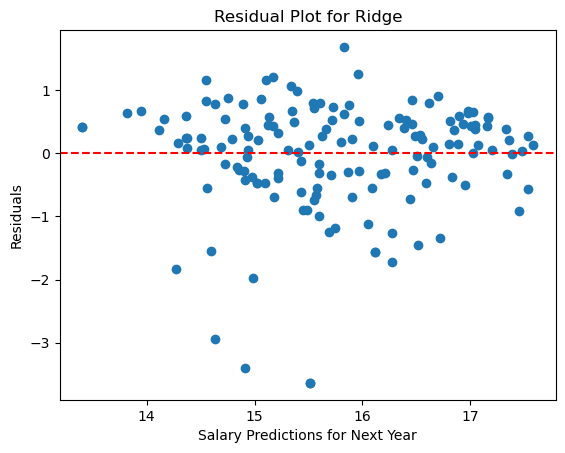

<Figure size 640x480 with 0 Axes>

In [9]:
ridge_residuals = y_test - ridge_pred
plt.scatter(ridge_pred, ridge_residuals)
plt.axhline(0, color='r', linestyle='--')
plt.title('Residual Plot for Ridge')
plt.xlabel('Salary Predictions for Next Year')
plt.ylabel('Residuals')
plt.show()
plt.savefig("outputs/Ridge_residual_plot.png")

Looking at the residual plot above, we see that it resembles the residual plot for OLS, where there the residuals between [14,16] are not randomly scattered. Therefore, a nonlinear model may be a better fit.

## LASSO Regression

Compared to ridge regression, LASSO will only retain features with great prediction power by shrinking the coefficients of irrelevant features to zero. This results in a model that is simpler in complexity, which additionally prevents overfitting. Since the residuals plots for OLS and ridge suggested that a nonlinear model may be better suited for this dataset, we will then use a random forest model to model the nonlinear relationship between the features selected by LASSO and salary.

Like ridge, we will also use 5-fold cross validation to find the best lambda/model on the standardized dataset.

In [10]:
warnings.filterwarnings("ignore")
lasso_model = LassoCV(cv=5)
lasso_model.fit(X_train_ss, y_train)
print("Best lambda for Lasso:", lasso_model.alpha_)

Best lambda for Lasso: 0.039218525026757704


Now that LASSO has peformed feature selection, we will use these selected features to train the random forest model with 70 estimators. Even though increasing the number of trees in the random forest model will decrease the MSE, we don't want to overfit.

In [11]:
selected = SelectFromModel(lasso_model, prefit=True)
X_train_selected = selected.transform(X_train_ss)
X_test_selected = selected.transform(X_test_ss)
print("Number of features before feature selection: ", X_train_ss.shape[1])
print("Number of features selected: ", X_train_selected.shape[1])
rf_model = RandomForestRegressor(n_estimators=70, random_state=42)
rf_model.fit(X_train_selected, y_train)
lasso_pred = rf_model.predict(X_test_selected)
lasso_mse = mse_func(y_test, lasso_pred)
print("LASSO MSE: ", lasso_mse)

Number of features before feature selection:  24
Number of features selected:  7
LASSO MSE:  0.4582229736507094


LASSO reduced model complexity by only using 9 out of the 24 features. We also see that the MSE for LASSO + random forests is much lower than the MSE for ridge or OLS, which proves there is probably a nonlinear relationship between the predictors and salary.

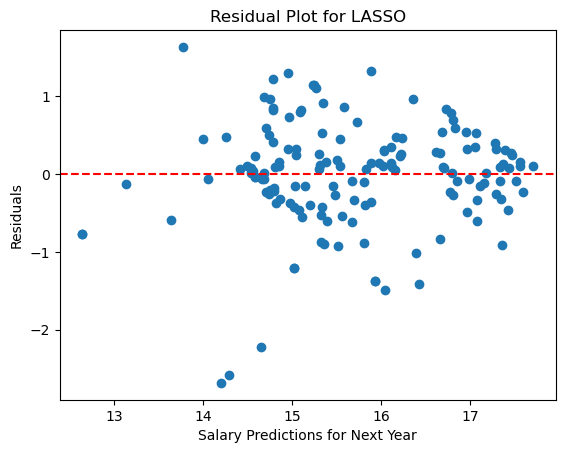

<Figure size 640x480 with 0 Axes>

In [12]:
lasso_residuals = y_test - lasso_pred
plt.scatter(lasso_pred, lasso_residuals)
plt.axhline(0, color='r', linestyle='--')
plt.title('Residual Plot for LASSO')
plt.xlabel('Salary Predictions for Next Year')
plt.ylabel('Residuals')
plt.show()
plt.savefig("outputs/LASSO_residual_plot.png")

Comparing this residual plot to the residual plots for OLS or ridge, we see that the residuals in this plot are slightly more randomly scattered. The outliers present in the other residual plots are no longer present in this plot as LASSO removes features that have low predictive power/noise.

## Results

We previously saw that only 9 out of the 24 features we are working with were used to train the random forest model. We will rank the 9 features by their predictive power as the other 15 features were deemed negligible by LASSO.

In [13]:
feature_contribution = pd.Series(rf_model.feature_importances_, index=X_train.columns[selected.get_support()]).sort_values(ascending=False)
print("Features from highest to lowest predictive power")
print(feature_contribution)

Features from highest to lowest predictive power
MP_x        0.638458
USG%        0.119001
Age         0.114557
BPM         0.103359
Pos_PG      0.012855
Pos_PF      0.010893
All-Star    0.000876
dtype: float64


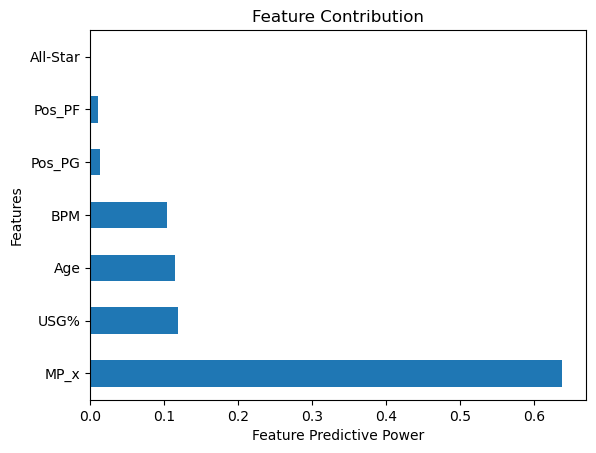

In [14]:
feature_contribution.plot(kind='barh')
plt.xlabel("Feature Predictive Power")
plt.ylabel("Features")
plt.title("Feature Contribution")
plt.show()
plt.savefig("outputs/feature_contribution.png")

Looking at the bar plot above, we see that out of the 9 features above, the players' minutes played per game was the most predictive of their next year's salary. Minutes played per game contributed to about 60% of the prediction while BPM and age were the 2nd and 3rd more predictive features, contributing about 11% and 7.5% resepectively. LASSO ignores the other 15 features for its predictions while ridge and OLS take all 24 features into account when predicting salary. Since LASSO + random forest resulted in the lowest MSE, we can conclude that a non-linear model using a subset of all the features to predict next year's salary is the best fit.